# 1 - Уменьшение палитры изображения 
Для <a href='https://thumbs.dreamstime.com/x/two-lorikeet-birds-2293918.jpg'> картинки </a> нужно уменьшить число цветов в палитре.

Для этого нужно выделить **кластеры в пространстве RGB**, объекты соответствуют пикселям изображения. После выделения кластеров, все пиксели, отнесенные в один кластер, заполняются одним цветом; этот цвет может быть центроидом соответствующего кластера, медианным цветом по кластеру.

Попробуйте различные алгоритмы кластеризации:

* KMeans
* DBSCAN
* AgglomerativeClustering

Рассмотрите число кластеров K = 2, 3, 10, 20 (в алгоритмах, где есть такой гиперпараметр).

Для различных кластеризаций оцените и сравните потери от уменьшения цветов при помощи метрики 
<a href='http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim'> SSIM </a>. Какой способ оказался лучшим?

Задание оценивает в 5 баллов.
Задание можно выполнять на своих картинках

In [1]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [2]:
import matplotlib.pyplot as plt
import cv2 # нужно поставить себе cv2 через conda install opencv

def draw_picture(image, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.show()

img - это обычный трехмерный массив цветов пикселей, где две первые координаты - это координаты каждого пикселя, и третья обозначает R, G или B.

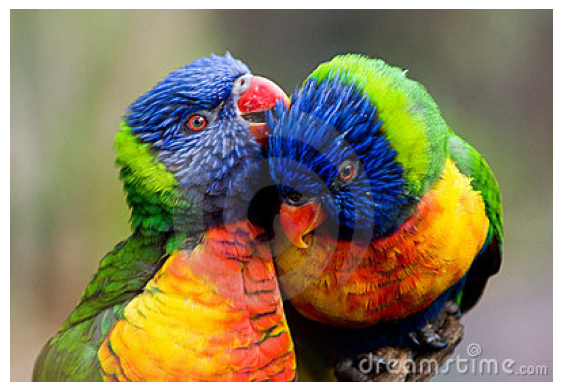

In [3]:
img = cv2.imread('birds.jpg') # считать картинку
draw_picture(img) # нарисовать картинку

In [7]:
print(img.shape) # сам img - это обычный трехмерный массив 275 x 400 x 3
# вам скорее все кстати понадобится сделать reshape, чтобы перейти от 275x400 к одномерному массиву пикселей

(275, 400, 3)


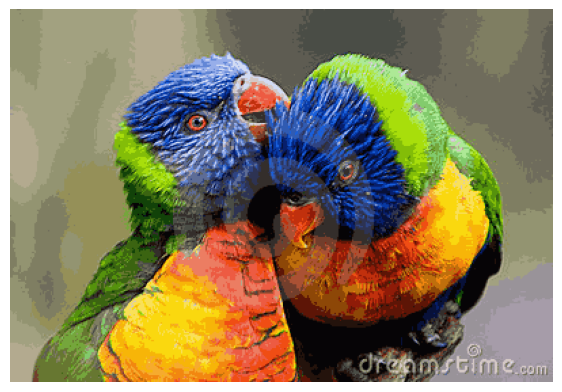

In [4]:
import numpy as np

X = img.reshape((-1,3)).astype(np.float32)

k = 50

kmeans = KMeans(n_clusters=k, random_state=123).fit(X)

center = kmeans.cluster_centers_
center = np.uint8(center)
center.shape
label = kmeans.labels_
res = center[label.flatten()]

result_image = res.reshape((img.shape))
draw_picture(result_image)

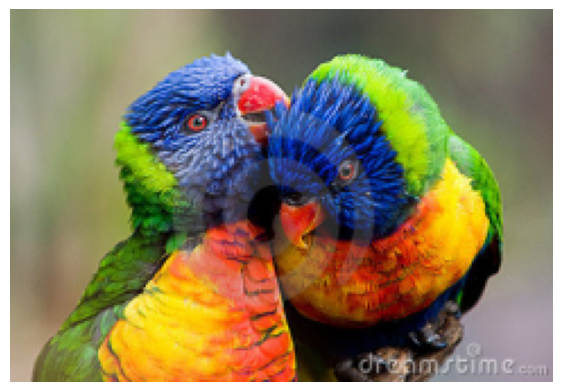

In [5]:
resize_ratio = 0.6
resized_height = img.shape[0] * resize_ratio
resized_width = img.shape[1] * resize_ratio
resized_img = cv2.resize(img, (int(resized_width), int(resized_height)), interpolation=cv2.INTER_AREA)
X_resized = resized_img.reshape((-1,3)).astype(np.float32)
draw_picture(resized_img)

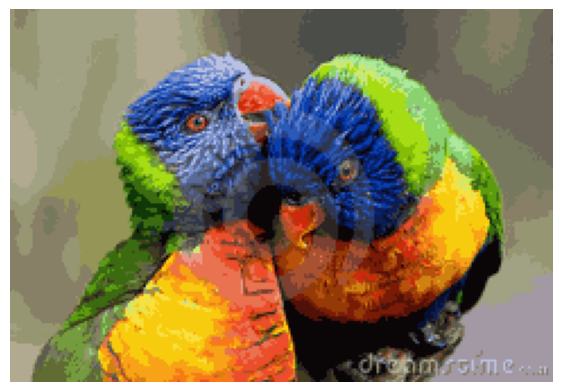

In [22]:
agglomerative_clustering = AgglomerativeClustering(n_clusters=50)
agglomerative_clustering.fit(X_resized)
masks = np.array([agglomerative_clustering.labels_ == i for i in range(agglomerative_clustering.n_clusters_)])
agglomerative_clusters_centers = np.array([np.mean(X_resized[mask], axis=0) for mask in masks])

agglomerative_clusters_centers = np.uint8(agglomerative_clusters_centers)
agglomerative_clusters_centers.shape
labels = agglomerative_clustering.labels_
res_agglomerative = agglomerative_clusters_centers[labels.flatten()]

result_image_agglomerative = res_agglomerative.reshape((resized_img.shape))
draw_picture(result_image_agglomerative)

Вычислим оптимальный epsilon, при котором бы основной шум отсеивался

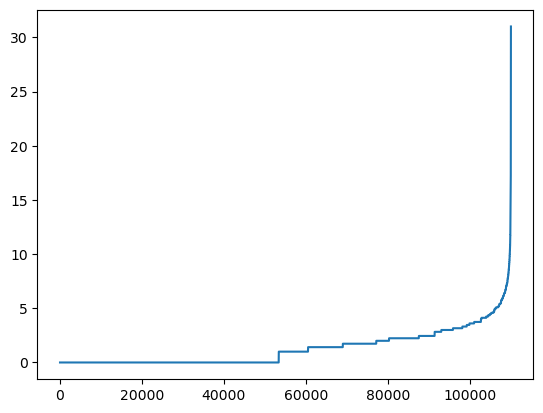

In [7]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

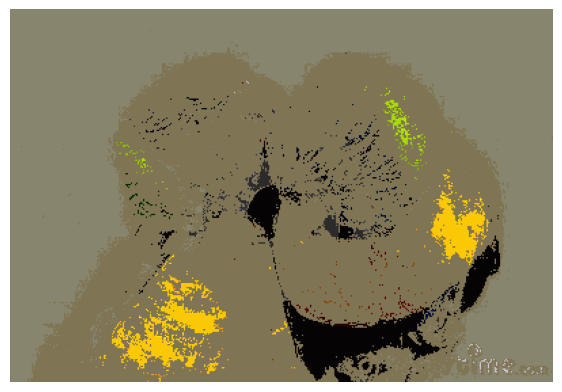

In [25]:
dbscan = DBSCAN(eps=3, min_samples=19)
dbscan.fit(X)
masks_dbscan = np.array([dbscan.labels_ == i for i in np.unique(dbscan.labels_)[1:]])
dbscan_clusters_centers = np.array([np.mean(X[mask], axis=0) for mask in masks_dbscan])
dbscan_clusters_centers = np.vstack([dbscan_clusters_centers, np.mean(X, axis=0)])
dbscan_clusters_centers = np.uint8(dbscan_clusters_centers)
dbscan_clusters_centers.shape
labels = dbscan.labels_
res_dbscan = dbscan_clusters_centers[labels.flatten()]
res_dbscan = res_dbscan.reshape((img.shape))
draw_picture(res_dbscan)

In [41]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [26]:
from skimage.metrics import structural_similarity as ssim
ssim_kmeans = ssim(result_image, img, data_range=result_image.max()-result_image.min(), channel_axis=2)
ssim_agglomerative = ssim(result_image_agglomerative, resized_img, data_range=result_image_agglomerative.max()-result_image_agglomerative.min(), channel_axis=2)
ssim_dbscan = ssim(res_dbscan, img, data_range=res_dbscan.max()-res_dbscan.min(), channel_axis=2)
print(' SSIM KMeans: {0}\n SSIM agglomerative clustering: {1}\n SSIM DBSCAN: {2}'.format(ssim_kmeans, ssim_agglomerative, ssim_dbscan))


 SSIM KMeans: 0.8261363376154338
 SSIM agglomerative clustering: 0.8274172410034382
 SSIM DBSCAN: 0.4465839942183702


Стоит заметить, что я использовал 50 кластеров в KMeans, 50 кластеров в агломеративной кластеризации и 45+1=46 кластеров в DBSCAN(я заменил выбросы на среднее значение RGB по картинке, так получился еще один кластер)

Агломеративная кластеризация показывает лучший SSIM, однако работает достаточно долго на оригинальном изображении, и даже на уменьшенном на 40% изображении время работы в 5 раз дольше, чем на оригинальном с KMeans, а SSIM остается практически таким же, как и на KMeans.

# 2 - Пишем K-Means сами

Написать K-Means и сравнить с моделькой из под sklearn.

Задание оценивается в 5 баллов

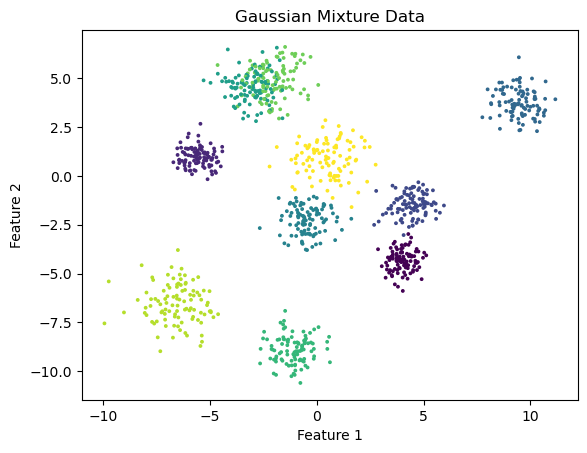

In [142]:
from sklearn.datasets import make_blobs

n_samples = 1000
n_features = 2
n_clusters = 10
cluster_std = np.linspace(0.5, 1, 10)

X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, cluster_std=cluster_std, random_state=123)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=3)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Gaussian Mixture Data')
plt.show()

In [117]:
class MyKMeans:
    def __init__(self, K, random_state):
        self._k = K
        self._labels = range(K)
        self._random_state = random_state

    def _set_init_centroids(self, X):
        self._centroids = np.random.default_rng(seed=self._random_state).choice(a=X, replace=False, shuffle=False, axis=0, size=self._k)
    
    def _reassign_labels(self, X):
        distances_matrix = np.array([np.sum((X-centroid)**2, axis=1)**0.5 for centroid in self._centroids])
        self._labels_vector = np.argmin(distances_matrix, axis=0)
    
    def _recalculate_centroids(self, X):
        self._centroids = np.array([X[self._labels_vector == label].mean(axis=0) for label in self._labels])

    def fit(self, X):
        self._set_init_centroids(X)
        self._reassign_labels(X)
        prev_labels_vector = self._labels_vector
        while True:
            self._recalculate_centroids(X)
            self._reassign_labels(X)
            if np.all(prev_labels_vector == self._labels_vector):
                break
            prev_labels_vector = self._labels_vector
        

In [121]:
my_kmeans = MyKMeans(10, random_state=123)
my_kmeans.fit(X)

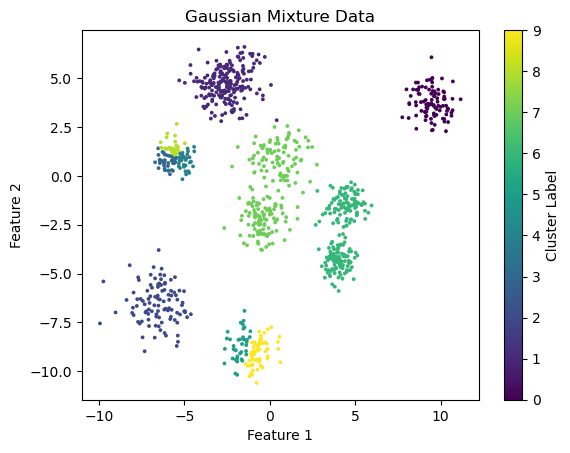

In [122]:
plt.scatter(X[:, 0], X[:, 1], c=my_kmeans._labels_vector, cmap='viridis', s=3)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Gaussian Mixture Data')
cbar = plt.colorbar(ticks=np.unique(my_kmeans._labels_vector))
cbar.set_label('Cluster Label')
plt.show()

In [131]:
from sklearn.metrics import silhouette_score
my_kmeans_silhouette_score = silhouette_score(X, my_kmeans._labels_vector, metric='euclidean', sample_size=X.shape[0], random_state=123)

sk_kmeans = KMeans(n_clusters=10, random_state=123).fit(X)
sk_kmeans_silhouette_score = silhouette_score(X, sk_kmeans.labels_.flatten(), metric='euclidean', sample_size=X.shape[0], random_state=123)
print('my KMeans silhouette score is {0}\nsklearn KMeans silhouette score is {1}'.format(my_kmeans_silhouette_score, sk_kmeans_silhouette_score))

my KMeans silhouette score is 0.5621032111271522
sklearn KMeans silhouette score is 0.6243338230358912


# 3 - Пишем DBSCAN сами (дополнительное задание на 5 баллов)

Аналогично предыдудщему заданию

In [139]:
class MyDBSCAN:
    def __init__(self, epsilon, min_samples):
        self._eps = epsilon
        self._min_samples = min_samples
    
    def _get_distance_matrix(self, X):
       return np.sum((X[:, np.newaxis] - X) ** 2, axis=-1) ** 0.5
    
    def fit(self, X):
        dist_matrix = self._get_distance_matrix(X)
        core_points_indexes = np.where(np.sum(dist_matrix <= self._eps, axis=1) > self._min_samples)[0]
        labels = []
        labels_vector = np.full(X.shape[0], -1).flatten()
        for core_point_index in core_points_indexes:
            core_distances = dist_matrix[core_point_index]
            dfs_stack_vector = core_distances <= self._eps
            dfs_stack = np.where(dfs_stack_vector)[0]
            assign_label = labels_vector[dfs_stack_vector & (labels_vector > -1)][0] if labels_vector[dfs_stack_vector & (labels_vector > -1)].size > 0 else len(labels)
            if assign_label == len(labels):
                labels.append(assign_label)
            while dfs_stack.size > 0:
                current_index = dfs_stack[-1]
                dfs_stack = dfs_stack[:-1]
                if labels_vector[current_index] == assign_label:
                    continue
                labels_vector[current_index] = assign_label
                dfs_stack = np.append(dfs_stack, np.where(dist_matrix[current_index] <= self._eps)[0])
        self._labels_vector = labels_vector
        self._labels = labels

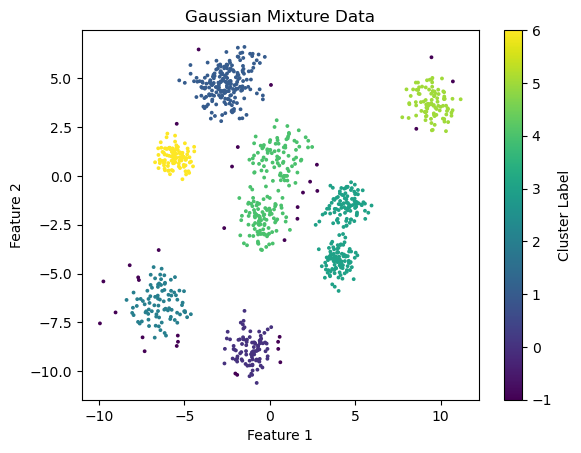

In [140]:
my_dbscan = MyDBSCAN(epsilon=0.6, min_samples=10)
my_dbscan.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=my_dbscan._labels_vector, cmap='viridis', s=3)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Gaussian Mixture Data')
cbar = plt.colorbar(ticks=np.unique(my_dbscan._labels_vector))
cbar.set_label('Cluster Label')
plt.show()

In [141]:
my_dbscan_silhouette_score = silhouette_score(X, my_dbscan._labels_vector, metric='euclidean', sample_size=X.shape[0], random_state=123)

sk_dbscan = DBSCAN(eps=0.6, min_samples=10).fit(X)
sk_dbscan_silhouette_score = silhouette_score(X, sk_dbscan.labels_, metric='euclidean', sample_size=X.shape[0], random_state=123)
print('my DBSCAN silhouette score is {0}\nsklearn DBSCAN silhouette score is {1}'.format(my_dbscan_silhouette_score, sk_dbscan_silhouette_score))

my DBSCAN silhouette score is 0.6279586598606857
sklearn DBSCAN silhouette score is 0.5952674202926569
